In [2]:
'''
Assignment 2
Student: NAME SURNAME
'''

# *** Packages ***
#!pip install torch==2.4 # Run just once
import torch.nn as nn
import torch.nn.functional as F
from math import floor
import torch

if __name__ == "__main__":
    # Write your code here
    print("Hello World!")

    '''
    DON'T MODIFY THE SEED!
    '''
    # Set the seed for reproducibility
    manual_seed = 42
    torch.manual_seed(manual_seed)

Hello World!


In [44]:
manual_seed = 42
torch.manual_seed(manual_seed)
# first dimension stay equal, second value change
torch.randint(1, 10 , (1,1))

tensor([[7]])

In [79]:
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Q4 - Normalize data
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)])

trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transformer)
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transformer)

Files already downloaded and verified
Files already downloaded and verified


In [80]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=len(testset))

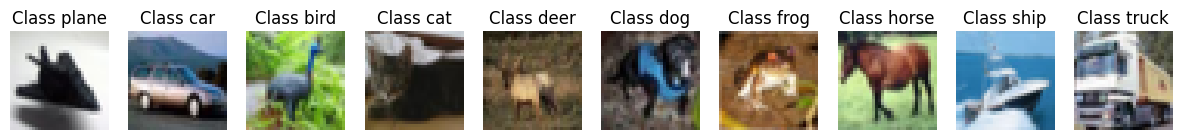

In [4]:
import torchvision

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Count the occurrences of each class for the train
labels = trainset.targets

train_counts = [0] * 10
for label in labels:
    train_counts[label] += 1

# Count the occurrences of each class for the test
labels = testset.targets
test_counts = [0] * 10
for label in labels:
    test_counts[label] += 1

# Get the labels and images
labels = trainset.targets
images = trainset.data

# Find an image for each class
class_images = [None] * 10
for i in range(len(labels)):
    label = labels[i]
    if class_images[label] is None:
        class_images[label] = images[i]
        
# Display the images
#class_images = torch.as_tensor(class_images)
fig, axs = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    axs[i].imshow(class_images[i])  # Permute dimensions for correct display
    axs[i].set_title(f"Class {classes[i]}")
    axs[i].axis('off')

plt.show()

In [ ]:
# Create the histogram
plt.bar(classes, train_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Train Set')

# Show the plot
plt.show()

In [ ]:
# Create the histogram
plt.bar(classes, test_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Test Set")

# Show the plot
plt.show()

In [ ]:
# Q3 - cast images
# we want a 3x32x32 => 3 channels, 32 width, 32 height
dataiter = iter(testloader)
images, labels = next(dataiter)

# [batch size, channels, height, width]
print(images.shape)
print(images[0].shape)

In [81]:
# Q5 - Make validation
import torch

validset, testset = torch.utils.data.random_split(testset, [0.5, 0.5])
testloader = DataLoader(testset, batch_size=len(testset))
validloader = DataLoader(validset, batch_size=len(validset))
print("We have", len(validset), "items for validation and", len(testset), "items for test")

We have 5000 items for validation and 5000 items for test


In [85]:
# Q6 - CNN
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
class CNNS(nn.Module):
    def __init__(self):
        super(CNNS, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.fc1 = nn.Linear(64 * h_out * w_out, 32)
        self.dimensions_final = (64, h_out, w_out)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [86]:
#Q7 - Training
import torch.optim as optim

model = CNNS()
learning_rate = 0.03 #0.031
n_epochs = 4 #7 might overfit but can be a minimum(?)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [87]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)
print()

train_count = 0
valid_count = 0

train_loss_list = []
validation_loss_list = []

print("Start Training...")
for epoch in range(n_epochs):
    loss_train = 0
    correct_train = 0

    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    
        # Calculate batch loss and batch accuracy
        _, predicted = torch.max(output.data, 1)  # Get the index of the maximum value
        correct_train += (predicted == target).sum().item()  # Count correct predictions
        train_count += len(data)  # Update train_count for accurate batch calculation

        # total batches 1562
        # Print train loss and accuracy every n batches
        if (train_count // batch_size) % ((len(trainloader)-1) // 3) == 0:
            train_accuracy = 100.0 * correct_train / train_count
            print(f"Epoch: {epoch + 1}, Batch {train_count // batch_size}: "
                    f"Train Loss: {loss_train / train_count:.4f}, Train Accuracy: {train_accuracy:.2f} %")

    train_accuracy = 100.0 * correct_train / train_count
    loss_train = loss_train / len(trainloader)
    train_loss_list.append(loss_train)
    print(f"Epoch: {epoch + 1}, Train Loss: {loss_train:.4f}, Train Accuracy: {train_accuracy:.2f} %")

    # Reset counters for next epoch
    train_count = 0  # Reset train_count for accurate batch calculation in next epoch
    
    # Validation at the end of each epoch
    with torch.no_grad():
        model.eval()
        loss_valid = 0
        correct_valid = 0

        for data, target in validloader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Make a prediction
            output = model(data)

            # Compute the loss function
            validation_loss = loss_fn(output, target)
            loss_valid += validation_loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(output.data, 1)
            correct_valid += (predicted == target).sum().item()
            valid_count += len(data)  # Update valid_count

            # No batch print because valid has only 1 batch

        # Epoch accuracy and loss calculations
        validation_accuracy = 100.0 * correct_valid / valid_count
        loss_valid = loss_valid / len(validloader)
        validation_loss_list.append(loss_valid)
        print(f"Epoch: {epoch + 1}, Validation Loss: {loss_valid:.4f}, Validation Accuracy: {validation_accuracy:.2f} %\n")

print("End Training...")

Working on cuda

Start Training...
Epoch: 1, Batch 520: Train Loss: 0.0692, Train Accuracy: 16.42 %
Epoch: 1, Batch 1040: Train Loss: 0.0647, Train Accuracy: 23.43 %
Epoch: 1, Batch 1560: Train Loss: 0.0605, Train Accuracy: 28.62 %
Epoch: 1, Train Loss: 1.9367, Train Accuracy: 28.63 %
Epoch: 1, Validation Loss: 1.5640, Validation Accuracy: 41.80 %

Epoch: 2, Batch 520: Train Loss: 0.0471, Train Accuracy: 45.24 %
Epoch: 2, Batch 1040: Train Loss: 0.0451, Train Accuracy: 47.91 %
Epoch: 2, Batch 1560: Train Loss: 0.0436, Train Accuracy: 49.93 %
Epoch: 2, Train Loss: 1.3941, Train Accuracy: 49.95 %
Epoch: 2, Validation Loss: 1.4880, Validation Accuracy: 25.26 %

Epoch: 3, Batch 520: Train Loss: 0.0381, Train Accuracy: 57.12 %
Epoch: 3, Batch 1040: Train Loss: 0.0369, Train Accuracy: 58.51 %
Epoch: 3, Batch 1560: Train Loss: 0.0359, Train Accuracy: 59.77 %
Epoch: 3, Train Loss: 1.1477, Train Accuracy: 59.77 %
Epoch: 3, Validation Loss: 1.0861, Validation Accuracy: 20.63 %

Epoch: 4, Batch 5

Using more than 4 epochs lead to overfitting, if we try with 15 epochs we can easly see that the loss during training will decrease for each epochs while the validation loss continue to go up and down showing a overfitting. 

Using a very high learning rate cause the training loss to decrease while validation loss will continue to increase, a very small learning rate will lead to a good accuracy after a lot of epochs.

i tried to add  more conv layer consecutively but it get worse, too loss of information (?), adding more layers is counter productive because it will need more epochs to have a good loss (tried 3 layers of 2 conv with relu and max but go overfitting)

In [88]:
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 67.16 %


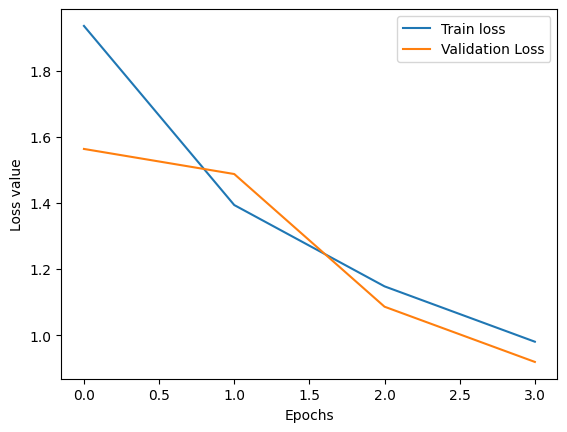

In [89]:
# Q8 - train and val loss
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [149]:
# Q9 - super cnn
import torch.nn as nn

def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out

class SCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SCNN, self).__init__()
        # Input layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        # Second block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        # Third block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv5, h_out, w_out)
        self.bn5 = nn.BatchNorm2d(128)
        #self.conv6 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=0, stride=1)
        #h_out, w_out = out_dimensions(self.conv6, h_out, w_out)
        #self.bn6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * h_out * w_out, 64)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.gelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.gelu(x)
        x = self.maxpool1(x)

        # Second block
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.gelu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.functional.gelu(x)
        x = self.maxpool2(x)

        # Third block
        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.functional.gelu(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn7(x)
        x = nn.functional.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

Files already downloaded and verified
Files already downloaded and verified
Working on cuda

Start Training...
Epoch: 1, Batch 520: Train Loss: 0.0585, Train Accuracy: 29.70 %
Epoch: 1, Batch 1040: Train Loss: 0.0534, Train Accuracy: 36.81 %
Epoch: 1, Batch 1560: Train Loss: 0.0501, Train Accuracy: 41.37 %
Epoch: 1, Train Loss: 1.6035, Train Accuracy: 41.39 %
Epoch: 1, Validation Loss: 1.3910, Validation Accuracy: 24.92 %

Epoch: 2, Batch 520: Train Loss: 0.0394, Train Accuracy: 56.41 %
Epoch: 2, Batch 1040: Train Loss: 0.0385, Train Accuracy: 57.16 %
Epoch: 2, Batch 1560: Train Loss: 0.0377, Train Accuracy: 58.20 %
Epoch: 2, Train Loss: 1.2052, Train Accuracy: 58.23 %
Epoch: 2, Validation Loss: 1.0892, Validation Accuracy: 31.62 %

Epoch: 3, Batch 520: Train Loss: 0.0329, Train Accuracy: 64.33 %
Epoch: 3, Batch 1040: Train Loss: 0.0329, Train Accuracy: 64.03 %
Epoch: 3, Batch 1560: Train Loss: 0.0326, Train Accuracy: 64.41 %
Epoch: 3, Train Loss: 1.0437, Train Accuracy: 64.43 %
Epoch:

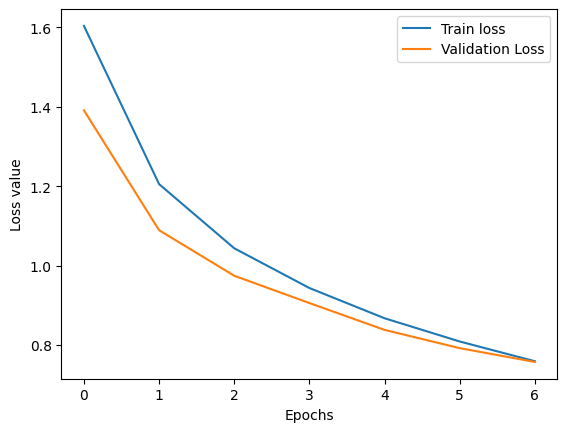

Accuracy on the test set: 74.46 %


In [150]:
import torch.optim as optim

# Q4 - Normalize data
transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ToTensor(), transforms.Normalize(mean=0, std=1)])

trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transformer)
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transformer)
validset, testset = torch.utils.data.random_split(testset, [0.5, 0.5])
testloader = DataLoader(testset, batch_size=len(testset))
validloader = DataLoader(validset, batch_size=len(validset))


model = SCNN()
learning_rate = 0.03 #0.03
n_epochs = 7
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)
print()

train_count = 0
valid_count = 0

train_loss_list = []
validation_loss_list = []

print("Start Training...")
for epoch in range(n_epochs):
    loss_train = 0
    correct_train = 0

    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    
        # Calculate batch loss and batch accuracy
        _, predicted = torch.max(output.data, 1)  # Get the index of the maximum value
        correct_train += (predicted == target).sum().item()  # Count correct predictions
        train_count += len(data)

        # Print train loss and accuracy every n batches
        if (train_count // batch_size) % ((len(trainloader)-1) // 3) == 0:
            train_accuracy = 100.0 * correct_train / train_count
            print(f"Epoch: {epoch + 1}, Batch {train_count // batch_size}: "
                    f"Train Loss: {loss_train / train_count:.4f}, Train Accuracy: {train_accuracy:.2f} %")

    train_accuracy = 100.0 * correct_train / train_count
    epoch_accuracy = (correct_train / len(trainloader)) / 100
    loss_train = loss_train / len(trainloader)
    train_loss_list.append(loss_train)
    print(f"Epoch: {epoch + 1}, Train Loss: {loss_train:.4f}, Train Accuracy: {train_accuracy:.2f} %")

    # Reset counters for next epoch
    train_count = 0
    
    # Validation at the end of each epoch
    with torch.no_grad():
        model.eval()
        loss_valid = 0
        correct_valid = 0

        for data, target in validloader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Make a prediction
            output = model(data)

            # Compute the loss function
            validation_loss = loss_fn(output, target)
            loss_valid += validation_loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(output.data, 1)
            correct_valid += (predicted == target).sum().item()

            # No batch print because valid has only 1 batch

        # Epoch accuracy and loss calculations
        validation_accuracy = (correct_valid / len(validloader)) / 100
        loss_valid = loss_valid / len(validloader)
        validation_loss_list.append(loss_valid)
        print(f"Epoch: {epoch + 1}, Validation Loss: {loss_valid:.4f}, Validation Accuracy: {validation_accuracy:.2f} %\n")

print("End Training...")

plt.figure()
plt.plot(range(1, n_epochs+1), train_loss_list)
plt.plot(range(1, n_epochs+1), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

In [151]:
'''
Q10 -  Code
'''
transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)])
for seed in range(5,10):
    trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transformer)
    testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transformer)
    validset, testset = torch.utils.data.random_split(testset, [0.5, 0.5])
    testloader = DataLoader(testset, batch_size=len(testset))
    validloader = DataLoader(validset, batch_size=len(validset))

    torch.manual_seed(seed)
    print("Seed equal to ", torch.random.initial_seed())
    
    model = CNNS()
    learning_rate = 0.03 #0.031
    n_epochs = 4 #7 might overfit but can be a minimum(?)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    model = model.to(DEVICE)

    train_count = 0
    valid_count = 0

    train_loss_list = []
    validation_loss_list = []

    #print("Start Training...")
    for epoch in range(n_epochs):
        loss_train = 0
        correct_train = 0

        for data, target in trainloader:
            # Set the model in training mode
            model.train()
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Set the gradient to 0
            optimizer.zero_grad()
            # Make a prediction
            output = model(data)
            # Compute the loss function
            loss = loss_fn(output, target)
            loss_train += loss.item()
            # Backpropagation
            loss.backward()
            # Update parameters
            optimizer.step()
        
            # Calculate batch loss and batch accuracy
            _, predicted = torch.max(output.data, 1)  # Get the index of the maximum value
            correct_train += (predicted == target).sum().item()  # Count correct predictions
            train_count += len(data)  # Update train_count for accurate batch calculation

            # total batches 1562
            # Print train loss and accuracy every n batches
            if (train_count // batch_size) % ((len(trainloader)-1) // 3) == 0:
                train_accuracy = 100.0 * correct_train / train_count
                #print(f"Epoch: {epoch + 1}, Batch {train_count // batch_size}: "
                        #f"Train Loss: {loss_train / train_count:.4f}, Train Accuracy: {train_accuracy:.2f} %")

        train_accuracy = 100.0 * correct_train / train_count
        loss_train = loss_train / len(trainloader)
        train_loss_list.append(loss_train)
        #print(f"Epoch: {epoch + 1}, Train Loss: {loss_train:.4f}, Train Accuracy: {train_accuracy:.2f} %")

        # Reset counters for next epoch
        train_count = 0  # Reset train_count for accurate batch calculation in next epoch
        
        # Validation at the end of each epoch
        with torch.no_grad():
            model.eval()
            loss_valid = 0
            correct_valid = 0

            for data, target in validloader:
                data, target = data.to(DEVICE), target.to(DEVICE)

                # Make a prediction
                output = model(data)

                # Compute the loss function
                validation_loss = loss_fn(output, target)
                loss_valid += validation_loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(output.data, 1)
                correct_valid += (predicted == target).sum().item()
                valid_count += len(data)  # Update valid_count

                # No batch print because valid has only 1 batch

            # Epoch accuracy and loss calculations
            validation_accuracy = 100.0 * correct_valid / valid_count
            loss_valid = loss_valid / len(validloader)
            validation_loss_list.append(loss_valid)
            #print(f"Epoch: {epoch + 1}, Validation Loss: {loss_valid:.4f}, Validation Accuracy: {validation_accuracy:.2f} %\n")

    # test
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, target in testloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += target.size(0)
            n_correct += (predicted == target).sum().item()

        acc = 100.0 * n_correct / n_samples
    print("Accuracy on the test set:", acc, "%\n")

Files already downloaded and verified
Files already downloaded and verified
Seed equal to  5
Accuracy on the test set: 65.36 %

Files already downloaded and verified
Files already downloaded and verified
Seed equal to  6
Accuracy on the test set: 59.6 %

Files already downloaded and verified
Files already downloaded and verified
Seed equal to  7
Accuracy on the test set: 59.62 %

Files already downloaded and verified
Files already downloaded and verified
Seed equal to  8
Accuracy on the test set: 66.38 %

Files already downloaded and verified
Files already downloaded and verified
Seed equal to  9
Accuracy on the test set: 62.02 %

